In [ ]:
ls

In [66]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import csv
from IPython.display import display

# =========================== 1. 定义反应物 ===========================
# 此处依然可以通过CSV读取数据，格式为(描述, SMILES)，例如：
import csv
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display

def load_reactants_from_csv(filename):
    """
    从CSV文件中读取反应物数据。
    CSV文件要求：
      - 第一列为描述（例如 "aldehydes_linker_1"）
      - 第二列为对应的 SMILES 字符串
    返回一个列表，每个元素为 (smiles, description) 的元组。
    """
    reactants = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        # 如果CSV文件有标题行，则先跳过
        headers = next(reader, None)
        for row in reader:
            # 如果行数据不足两列则跳过
            if len(row) < 2:
                continue
            description = row[0].strip()
            smiles = row[1].strip()
            reactants.append((smiles, description))
    return reactants

# 分别从CSV中读取三类反应物数据
amines = load_reactants_from_csv('A3-coupling-2_header.csv')
aldehydes = load_reactants_from_csv('A3-coupling-2_linker.csv')
alkynes = load_reactants_from_csv('A3-coupling-2_tail.csv')

# 打印读取的内容
print("Amines:")
for smiles, desc in amines:
    print(f"{desc}: {smiles}")

print("\nAldehydes:")
for smiles, desc in aldehydes:
    print(f"{desc}: {smiles}")

print("\nAlkynes:")
for smiles, desc in alkynes:
    print(f"{desc}: {smiles}")



Amines:
h1: CN
h2: CCN
h3: COCCN
h4: NCCO
h5: NC1CCCCC1
h6: NC1=CC=CC=C1
h7: N[C@H]1CC[C@H](O)CC1
h8: COC(=O)CN
h9: CN(C)CCN
h10: CN(C)CCCN
h11: CCN(CC)CCN
h12: CCN(CC)CCCN
h13: NCCN1CCCC1
h14: NCCCN1CCCC1
h15: NCCCN1C=CN=C1
h16: NCCN1CCOCC1
h17: NCCN1CCCCC1
h18: CN1CCN(CCCN)CC1
h19: C1CNCCN1
h20: CNCCCNC
h21: CCNCCNCC
h22: CNCCCN(C)CCCNC
h23: NCCNCCO
h24: NCCN
h25: NCCCN
h26: NCCOCCOCCN
h27: CN(CCN)CCN
h28: CN(CCCN)CCCN
h29: NCCN(CCN)CCN
h30: NCCCN1CCN(CCCN)CC1

Aldehydes:
l1: C=O

Alkynes:
t1: C#CC1=CC=C(CCCC)C=C1
t2: C#CC1=CC=C(CCCCCC)C=C1
t3: C#CC1=CC=C(C2CCC(CCC)CC2)C=C1
t4: C#CCCCCCCCC
t5: C#CCCCCCCCCCCCC
t6: C#CCCCCCCCCCCCCCCCC


In [67]:
# =========================== 5. 定义处理及保存产物的函数 ===========================
def process_and_save_products(product_tuples, step_name):
    """
    处理产品：
    1) 去重 & 转 SMILES（保留产品名称）
    2) 打印 SMILES 到控制台
    3) 输出有效产物到 CSV: f"{step_name}_products.csv"
    4) （可选）在 Notebook 中显示网格图
    5) 返回去重并检查后的有效产物及其名称列表
    """
    import csv
    from rdkit import Chem
    from rdkit.Chem import Draw
    from IPython.display import display

    if not product_tuples:
        print(f"[{step_name}] 没有产物生成.")
        return [], []

    # 1) 去重（根据 SMILES 去重，同时保留名称，保留第一次出现的名称）
    unique_dict = {}
    for mol, name in product_tuples:
        smi = Chem.MolToSmiles(mol, isomericSmiles=True)
        if smi not in unique_dict:
            unique_dict[smi] = name
    unique_smiles = list(unique_dict.keys())
    print(f"[{step_name}] 原产物数: {len(product_tuples)}, 去重后: {len(unique_smiles)}")

    # 2) 在控制台打印 SMILES 列表
    print(f"[{step_name}] 产物 SMILES 列表 (去重后):")
    for smi in unique_smiles:
        print("  ", smi)

    # 3) 转回 Mol，并进行 Sanitize 检查，同时收集有效产品的名称
    valid_mols = []
    valid_names = []
    invalid_smiles = []
    for smi in unique_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            print(f"[警告] 无法从 SMILES 解析: {smi}")
            invalid_smiles.append(smi)
            continue
        try:
            Chem.SanitizeMol(mol)
            valid_mols.append(mol)
            valid_names.append(unique_dict[smi])
        except Exception as e:
            print(f"[非法产物] SMILES: {smi} | 错误: {e}")
            invalid_smiles.append(smi)
    print(f"[{step_name}] Sanitize 检查后有效产物数: {len(valid_mols)}，非法产物数: {len(invalid_smiles)}")

    # 4) 保存有效产物 CSV（包括编号、名称和 SMILES）
    csv_filename = f"{step_name}_products.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["编号", "名称", "SMILES"])
        for idx, (mol, name) in enumerate(zip(valid_mols, valid_names), start=1):
            smi = Chem.MolToSmiles(mol, isomericSmiles=True)
            writer.writerow([idx, name, smi])
    print(f"[{step_name}] 有效产物 CSV 已保存: {csv_filename}")

    # 5) 保存非法产物 CSV（如果有）
    if invalid_smiles:
        invalid_csv_filename = f"{step_name}_invalid_products.csv"
        with open(invalid_csv_filename, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["SMILES"])
            for smi in invalid_smiles:
                writer.writerow([smi])
        print(f"[{step_name}] 非法产物 CSV 已保存: {invalid_csv_filename}")

    # 6) 在 Notebook 中显示网格图
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200))
        display(img)
        # 如需保存图片，可启用如下代码：
        # png_filename = f"{step_name}_products.png"
        # img_data = Draw.MolsToGridImage(valid_mols, molsPerRow=4, subImgSize=(200, 200), returnPNG=True)
        # with open(png_filename, "wb") as f:
        #     f.write(img_data)
        # print(f"[{step_name}] 图片已保存: {png_filename}")

    return valid_mols, valid_names




In [68]:
# ---------------------- 2. 定义两步反应 ----------------------
# Reaction 1 SMARTS：胺 + 醛 + 炔 -> 中间体（接入第一个 propargyl 单元）
rxn1_smarts = '[N;H1,H2:1].[C:2]=O.[CH:3]#[C:4] >> [N:1]-[C:2][C:3]#[C:4]'
#rxn1_smarts = '[N;H1,H2:1].[C:2]=[O:3].[CH:4]#[C:5] >> [N:1]-[C:2]([C:4]#[C:5])'
#rxn1_smarts = '[NH:1].[C:2]=O.[CH:3]#[C:4] >> [N:1]-[C:2][C:3]#[C:4]'


rxn1 = AllChem.ReactionFromSmarts(rxn1_smarts)
print("Reaction 1 有效性:", rxn1.IsInitialized())

# ---------------------- 3. 将反应物转换为RDKit分子 ----------------------
# 对于醛和炔，我们使用CSV中读取的数据
# 假设只取第一个醛
aldehyde_smiles, aldehyde_desc = aldehydes[0]
aldehyde_mol = Chem.MolFromSmiles(aldehyde_smiles)
if aldehyde_mol is None:
    raise ValueError(f"Aldehyde SMILES 无法解析：{aldehyde_smiles}")

# 将所有炔类反应物转换为Mol对象，并保存对应描述
alkyne_mols = []
for smi, desc in alkynes:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        alkyne_mols.append(mol)
if not alkyne_mols:
    raise ValueError("所有炔类反应物均无法解析！")



Reaction 1 有效性: False



中间产物数: 258
[intermediate] 原产物数: 258, 去重后: 186
[intermediate] 产物 SMILES 列表 (去重后):
   CCCCc1ccc(C#CCNC)cc1
   CCCCCCc1ccc(C#CCNC)cc1
   CCCC1CCC(c2ccc(C#CCNC)cc2)CC1
   CCCCCCCCC#CCNC
   CCCCCCCCCCCCC#CCNC
   CCCCCCCCCCCCCCCCC#CCNC
   CCCCc1ccc(C#CCNCC)cc1
   CCCCCCc1ccc(C#CCNCC)cc1
   CCCC1CCC(c2ccc(C#CCNCC)cc2)CC1
   CCCCCCCCC#CCNCC
   CCCCCCCCCCCCC#CCNCC
   CCCCCCCCCCCCCCCCC#CCNCC
   CCCCc1ccc(C#CCNCCOC)cc1
   CCCCCCc1ccc(C#CCNCCOC)cc1
   CCCC1CCC(c2ccc(C#CCNCCOC)cc2)CC1
   CCCCCCCCC#CCNCCOC
   CCCCCCCCCCCCC#CCNCCOC
   CCCCCCCCCCCCCCCCC#CCNCCOC
   CCCCc1ccc(C#CCNCCO)cc1
   CCCCCCc1ccc(C#CCNCCO)cc1
   CCCC1CCC(c2ccc(C#CCNCCO)cc2)CC1
   CCCCCCCCC#CCNCCO
   CCCCCCCCCCCCC#CCNCCO
   CCCCCCCCCCCCCCCCC#CCNCCO
   CCCCc1ccc(C#CCNC2CCCCC2)cc1
   CCCCCCc1ccc(C#CCNC2CCCCC2)cc1
   CCCC1CCC(c2ccc(C#CCNC3CCCCC3)cc2)CC1
   CCCCCCCCC#CCNC1CCCCC1
   CCCCCCCCCCCCC#CCNC1CCCCC1
   CCCCCCCCCCCCCCCCC#CCNC1CCCCC1
   CCCCc1ccc(C#CCNc2ccccc2)cc1
   CCCCCCc1ccc(C#CCNc2ccccc2)cc1
   CCCC1CCC(c2ccc(C#CCNc3ccccc3

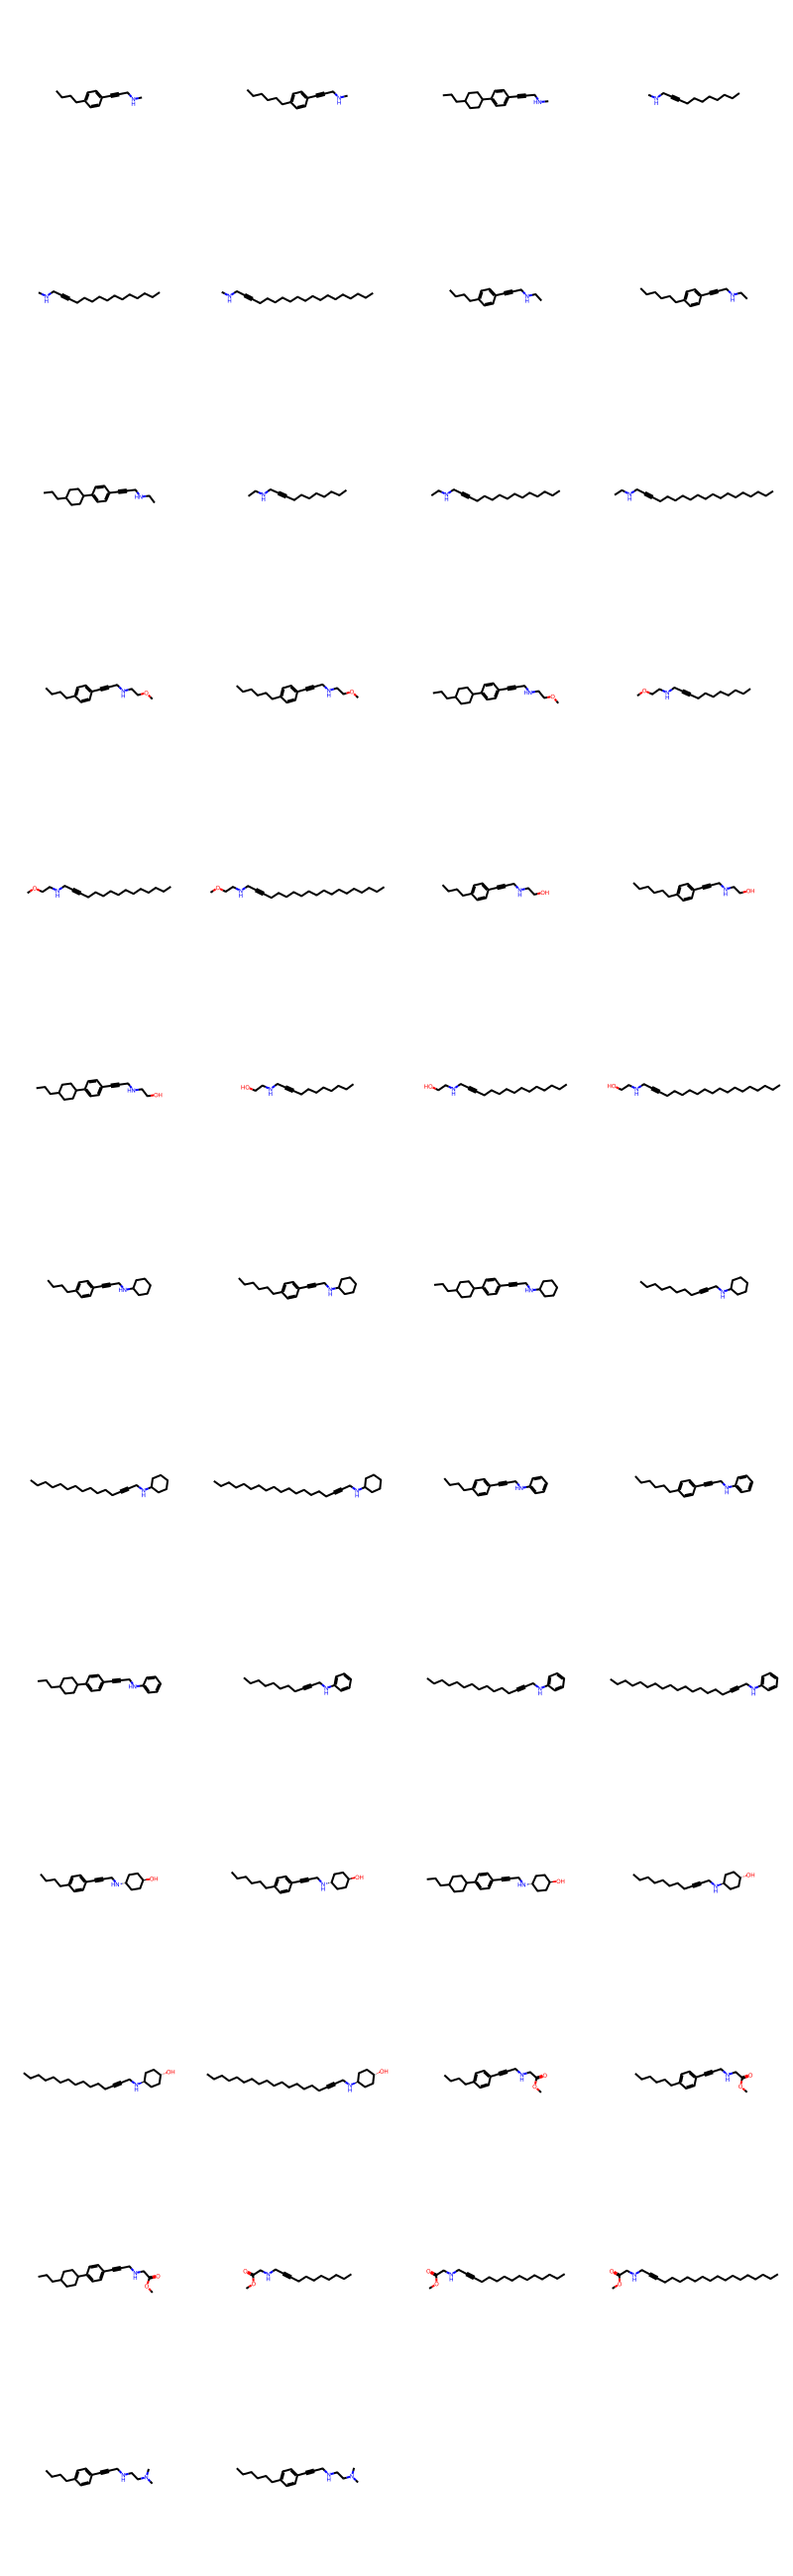

In [69]:
# ---------------------- 4. 执行两步反应 ----------------------
# 保存中间产物 (mol, name) 和最终产物 (mol, name)
intermediate_products = []


# Reaction 1: 胺 + 醛 + 炔1 → 中间体
for amine_smiles, amine_desc in amines:
    amine_mol = Chem.MolFromSmiles(amine_smiles)
    if amine_mol is None:
        print(f"[警告] 无效胺: {amine_smiles}")
        continue
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        aldehyde_mol = Chem.MolFromSmiles(aldehyde_smiles)
        if aldehyde_mol is None:
            print(f"[警告] 无效醛: {aldehyde_smiles}")
            continue
        for alkyne_smiles, alkyne_desc in alkynes:
            alkyne_mol = Chem.MolFromSmiles(alkyne_smiles)
            if alkyne_mol is None:
                print(f"[警告] 无效炔: {alkyne_smiles}")
                continue
            reactants1 = (amine_mol, aldehyde_mol, alkyne_mol)
            products1 = rxn1.RunReactants(reactants1)
            for prod_tuple in products1:
                for prod in prod_tuple:
                    try:
                        Chem.SanitizeMol(prod)
                        # 生成中间产物名称，例如 "amineDesc_aldehydeDesc_alkyneDesc"
                        inter_name = f"{amine_desc}_{aldehyde_desc}_{alkyne_desc}"
                        intermediate_products.append((prod, inter_name))
                    except Exception as e:
                        print(f"[非法中间体] {Chem.MolToSmiles(prod)} | 错误: {e}")
                        continue

print(f"\n中间产物数: {len(intermediate_products)}")


# 使用之前定义的函数保存中间产物和最终产物到 CSV，并在 Notebook 中显示产品网格图
valid_intermediates, inter_names = process_and_save_products(intermediate_products, "intermediate")



In [ ]:
print(f"\n中间产物数: {len(intermediate_products)}")

Reaction 2 有效性: False

最终产物数: 2232
[final] 原产物数: 2232, 去重后: 813
[final] 产物 SMILES 列表 (去重后):
   CCCCc1ccc(C#CCN(C)CC#Cc2ccc(CCCC)cc2)cc1
   CCCCCCc1ccc(C#CCN(C)CC#Cc2ccc(CCCC)cc2)cc1
   CCCCc1ccc(C#CCN(C)CC#Cc2ccc(C3CCC(CCC)CC3)cc2)cc1
   CCCCCCCCC#CCN(C)CC#Cc1ccc(CCCC)cc1
   CCCCCCCCCCCCC#CCN(C)CC#Cc1ccc(CCCC)cc1
   CCCCCCCCCCCCCCCCC#CCN(C)CC#Cc1ccc(CCCC)cc1
   CCCCCCc1ccc(C#CCN(C)CC#Cc2ccc(CCCCCC)cc2)cc1
   CCCCCCc1ccc(C#CCN(C)CC#Cc2ccc(C3CCC(CCC)CC3)cc2)cc1
   CCCCCCCCC#CCN(C)CC#Cc1ccc(CCCCCC)cc1
   CCCCCCCCCCCCC#CCN(C)CC#Cc1ccc(CCCCCC)cc1
   CCCCCCCCCCCCCCCCC#CCN(C)CC#Cc1ccc(CCCCCC)cc1
   CCCC1CCC(c2ccc(C#CCN(C)CC#Cc3ccc(C4CCC(CCC)CC4)cc3)cc2)CC1
   CCCCCCCCC#CCN(C)CC#Cc1ccc(C2CCC(CCC)CC2)cc1
   CCCCCCCCCCCCC#CCN(C)CC#Cc1ccc(C2CCC(CCC)CC2)cc1
   CCCCCCCCCCCCCCCCC#CCN(C)CC#Cc1ccc(C2CCC(CCC)CC2)cc1
   CCCCCCCCC#CCN(C)CC#CCCCCCCCC
   CCCCCCCCC#CCN(C)CC#CCCCCCCCCCCCC
   CCCCCCCCC#CCN(C)CC#CCCCCCCCCCCCCCCCC
   CCCCCCCCCCCCC#CCN(C)CC#CCCCCCCCCCCCC
   CCCCCCCCCCCCC#CCN(C)CC#CCCCCCCCCCCCCCC

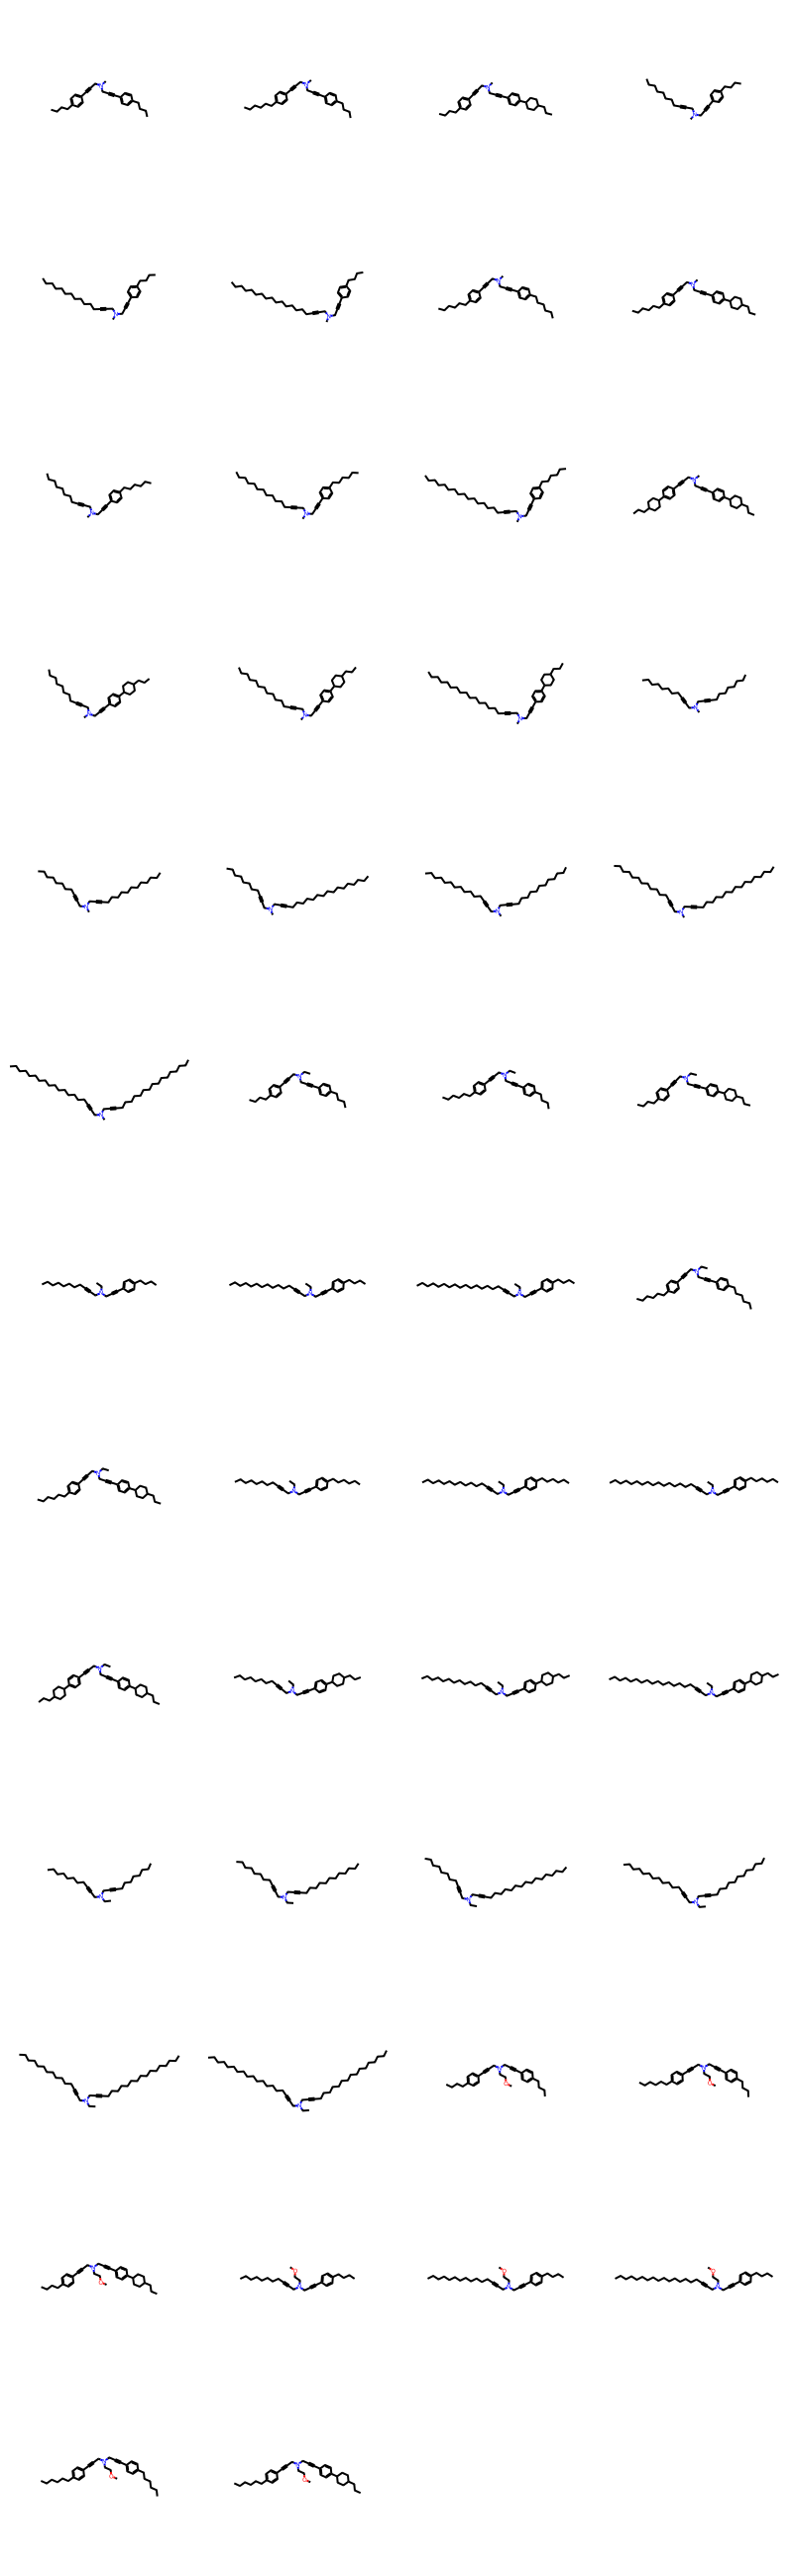

In [70]:
# Reaction 2: 中间体 + 醛 + 炔2 → 最终产物
# 在中间产物中假设存在未反应的 N–H，可以接入第二个 propargyl 单元
# Reaction 2 SMARTS：在中间体中任一未反应的 N–H 上再接入第二个 propargyl 单元
rxn2_smarts = '[N;H1,H2:1].[C:2]=O.[CH:3]#[C:4] >> [N:1]-[C:2][C:3]#[C:4]'
rxn2 = AllChem.ReactionFromSmarts(rxn2_smarts)
print("Reaction 2 有效性:", rxn2.IsInitialized())

#rxn1_smarts = '[N;H1,H2:1].[C:2]=O.[CH:3]#[C:4] >> [N:1]-[C:2][C:3]#[C:4]'

final_products = []
for inter_mol, inter_name in intermediate_products:
    for aldehyde_smiles, aldehyde_desc in aldehydes:
        aldehyde_mol = Chem.MolFromSmiles(aldehyde_smiles)
        if aldehyde_mol is None:
            print(f"[警告] 无效醛: {aldehyde_smiles}")
            continue
        for alkyne_smiles, alkyne_desc in alkynes:
            alkyne_mol = Chem.MolFromSmiles(alkyne_smiles)
            if alkyne_mol is None:
                print(f"[警告] 无效炔: {alkyne_smiles}")
                continue
            reactants2 = (inter_mol, aldehyde_mol, alkyne_mol)
            products2 = rxn2.RunReactants(reactants2)
            for prod_tuple in products2:
                for prod in prod_tuple:
                    try:
                        Chem.SanitizeMol(prod)
                        # 生成最终产物名称，例如 "interName_aldehydeDesc_alkyneDesc"
                        final_name = f"{inter_name}_{aldehyde_desc}_{alkyne_desc}"
                        final_products.append((prod, final_name))
                    except Exception as e:
                        print(f"[非法最终产物] {Chem.MolToSmiles(prod)} | 错误: {e}")
                        continue

print(f"\n最终产物数: {len(final_products)}")
valid_finals, final_names = process_and_save_products(final_products, "final")

In [71]:
import csv
import os
from rdkit import Chem
from rdkit.Chem import Draw

def process_csv(csv_filename):
    """
    读取CSV文件，假设文件包含标题行，标题至少包含：
      - "编号"
      - "名称"
      - "SMILES"
    对每一行，生成RDKit分子，并将PNG图片和MOL文件分别保存到新建的文件夹 "png_files" 和 "mol_files" 中。
    """
    # 创建用于保存PNG和MOL文件的文件夹
    png_folder = "png_files"
    mol_folder = "mol_files"
    os.makedirs(png_folder, exist_ok=True)
    os.makedirs(mol_folder, exist_ok=True)
    
    with open(csv_filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # 获取编号、名称和SMILES（根据实际CSV标题调整）
            mol_id = row.get("编号", "").strip()
            mol_name = row.get("名称", "").strip()
            smiles = row.get("SMILES", "").strip()
            
            if not smiles:
                print("空的SMILES，跳过此行。")
                continue
            
            # 使用RDKit从SMILES生成分子
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"无法解析 SMILES: {smiles}，跳过。")
                continue

            # 尝试进行化学有效性检查
            try:
                Chem.SanitizeMol(mol)
            except Exception as e:
                print(f"分子 {smiles} 清洗失败: {e}，跳过。")
                continue

            # 构造文件名前缀：优先使用编号和名称，例如“h1_l1_t1”
            if mol_id and mol_name:
                prefix = f"{mol_id}_{mol_name}"
            else:
                prefix = mol_id or mol_name or "molecule"
            # 清除空格和特殊字符，确保文件名安全
            prefix = "".join(c for c in prefix if c.isalnum() or c in ['-', '_'])
            if not prefix:
                prefix = "molecule"
            
            # 保存为PNG图片到png_folder
            png_filename = os.path.join(png_folder, f"{prefix}.png")
            try:
                Draw.MolToFile(mol, png_filename, size=(300, 300))
                print(f"已保存PNG图片: {png_filename}")
            except Exception as e:
                print(f"保存PNG失败: {e}")

            # 保存为MOL格式文件到mol_folder
            mol_filename = os.path.join(mol_folder, f"{prefix}.mol")
            try:
                Chem.MolToMolFile(mol, mol_filename)
                print(f"已保存MOL文件: {mol_filename}")
            except Exception as e:
                print(f"保存MOL文件失败: {e}")

if __name__ == "__main__":
    # 请将下面的文件路径替换成实际CSV文件的路径
    csv_filename = "final_products.csv"
    if os.path.exists(csv_filename):
        process_csv(csv_filename)
    else:
        print(f"文件 {csv_filename} 不存在，请检查路径。")


已保存PNG图片: png_files/1_h1_l1_t1_l1_t1.png
已保存MOL文件: mol_files/1_h1_l1_t1_l1_t1.mol
已保存PNG图片: png_files/2_h1_l1_t1_l1_t2.png
已保存MOL文件: mol_files/2_h1_l1_t1_l1_t2.mol
已保存PNG图片: png_files/3_h1_l1_t1_l1_t3.png
已保存MOL文件: mol_files/3_h1_l1_t1_l1_t3.mol
已保存PNG图片: png_files/4_h1_l1_t1_l1_t4.png
已保存MOL文件: mol_files/4_h1_l1_t1_l1_t4.mol
已保存PNG图片: png_files/5_h1_l1_t1_l1_t5.png
已保存MOL文件: mol_files/5_h1_l1_t1_l1_t5.mol
已保存PNG图片: png_files/6_h1_l1_t1_l1_t6.png
已保存MOL文件: mol_files/6_h1_l1_t1_l1_t6.mol
已保存PNG图片: png_files/7_h1_l1_t2_l1_t2.png
已保存MOL文件: mol_files/7_h1_l1_t2_l1_t2.mol
已保存PNG图片: png_files/8_h1_l1_t2_l1_t3.png
已保存MOL文件: mol_files/8_h1_l1_t2_l1_t3.mol
已保存PNG图片: png_files/9_h1_l1_t2_l1_t4.png
已保存MOL文件: mol_files/9_h1_l1_t2_l1_t4.mol
已保存PNG图片: png_files/10_h1_l1_t2_l1_t5.png
已保存MOL文件: mol_files/10_h1_l1_t2_l1_t5.mol
已保存PNG图片: png_files/11_h1_l1_t2_l1_t6.png
已保存MOL文件: mol_files/11_h1_l1_t2_l1_t6.mol
已保存PNG图片: png_files/12_h1_l1_t3_l1_t3.png
已保存MOL文件: mol_files/12_h1_l1_t3_l1_t3.mol
已保存PNG图片: 

In [ ]:
# =========================== 6. 调用处理函数 ===========================
final_unique_products, final_product_names = process_and_save_products(product_mols, "A3_2")
#valid_intermediates, inter_names = process_and_save_products(intermediate_products, "intermediate")
